# Lead-Acid Models

We compare a standard porous-electrode model for lead-acid batteries with two asymptotic reductions. For a more in-depth introduction to PyBaMM models, see the [SPM notebook](./SPM.ipynb). Further details on the models can be found in [[1]](#ref)

<a name="ref">[1]</a> Sulzer, Valentin, S. Jon Chapman, Colin P. Please, David A. Howey, and Charles W. Monroe. "Faster Lead-Acid Battery Simulations from Porous-Electrode Theory: II. Asymptotic Analysis." arXiv preprint arXiv:1902.01774 (2019).

In [1]:
import pybamm
import numpy as np
import os
import matplotlib.pyplot as plt
os.chdir(pybamm.__path__[0]+'/..')

### "Full" model

#### Electrolyte Concentration

$$
    \frac{\partial }{\partial t}\left(\epsilon c\right) = -\frac{\partial N}{\partial x} + sj, \\ 
    N = -\frac{\epsilon^b  D(c)}{\mathcal{C}_\text{e}}  \frac{\partial c}{\partial x}\\
    N\big|_{x=0}= N\big|_{x=1}=0, \\ 
    c\big|_{t=0} = 1
$$ 

#### Porosity

$$
    \frac{\partial \epsilon}{\partial t} = -\beta^\text{surf}j, \\  
    \epsilon\big|_{t=0} = \epsilon^0
$$ 

#### Electrolyte Current 

$$
    \frac{\partial i_{\text{e}}}{\partial x} = j, \\
    \mathcal{C}_\text{e} i_{\text{e}} = \epsilon_k^b \kappa(c) 
        \left( \chi \frac{\partial}{\partial x}\log(c) 
        - \frac{\partial\phi_{\text{e}}}{\partial x}\right)\\
    i_{\text{e}}\big|_{x=0}= i_{\text{e}}\big|_{x=1}=0,
$$

#### Electrode Current 

$$
    \frac{\partial i_{\text{s}}}{\partial x} = -j,\\
    i_{\text{s}} = -\sigma\frac{\partial\phi_{\text{s}}}{\partial x},\\
    \phi_{\text{s}}\big|_{x=0}
        = i_{\text{s}}\big|_{x=l_\text{n}} 
        = i_{\text{s}}\big|_{x=1-l_\text{p}} = 0, \\
    i_{\text{s}}\big|_{x=1}=\mathcal{I},
$$


#### interfacial current density

$$
j = \begin{cases}
    2j_0(c) \sinh\left(\eta\right), \quad &0 < x < l_\text{n} \\
    0, \quad &l_\text{n} < x < 1-l_\text{p} \\
    2j_0(c) \sinh\left(\eta\right), \quad &1-l_\text{p} < x < 1 
\end{cases}
\\
\eta = \phi_{\text{s}} - \phi_\text{e} - U(c),
$$


This model is implemented in PyBaMM as the `Full` model 

In [2]:
full = pybamm.lead_acid.Full()

### "Leading-order" model 

$$
    \frac{\mathrm{d} }{\mathrm{d} t}\left(\epsilon c\right) = (s_\text{n} - s_\text{p})\mathrm{I}, \\
    \frac{\mathrm{d} \epsilon}{\mathrm{d} t} = -\beta^\text{surf}j, \\
    j = \begin{cases}
        \mathrm{I}/l_\text{n}, \quad &0 < x < l_\text{n} \\
        0, \quad &l_\text{n} < x < 1-l_\text{p} \\
        -\mathrm{I}/l_\text{p}, \quad &1-l_\text{p} < x < 1 
    \end{cases} \\
    \phi_\text{e} = -U_\text{n}(c) + \sinh^{-1}\left(\frac{\mathrm{I}}{2l_\text{n}j_{0\text{n}}(c)}\right) \\
    V = -\phi_\text{e} + U_\text{p}(c) - \sinh^{-1}\left(\frac{\mathrm{I}}{2l_\text{p}j_{0\text{p}}(c)}\right) \\
$$

This model is implemented in PyBaMM as `LOQS` (leading-order quasi-static)

In [3]:
loqs = pybamm.lead_acid.LOQS()

### "Composite" model

#### Electrolyte Concentration

$$
    \frac{\partial }{\partial t}\left(\epsilon c\right) = -\frac{\partial N}{\partial x} + sj, \\ 
    N = -\frac{\epsilon^b  D(c)}{\mathcal{C}_\text{e}}  \frac{\partial c}{\partial x}\\
    N\big|_{x=0}= N\big|_{x=1}=0, \\ 
    c\big|_{t=0} = 1
$$ 

#### Porosity

$$
    \frac{\partial \epsilon}{\partial t} = -\beta^\text{surf}j, \\  
    \epsilon\big|_{t=0} = \epsilon^0
$$ 

#### Interfacial current density

$$
j = \begin{cases}
        \mathrm{I}/l_\text{n}, \quad &0 < x < l_\text{n} \\
        0, \quad &l_\text{n} < x < 1-l_\text{p} \\
        -\mathrm{I}/l_\text{p}, \quad &1-l_\text{p} < x < 1 
    \end{cases} \\
$$

#### Voltage 

$$ 
V = U_{\text{eq}} + \eta_r + \eta_c + \Delta\Phi_{\text{Elec}} + \Delta\Phi_{\text{Solid}}
$$ 
where 
\begin{align}
    & U_{\text{eq}} = U_p(\bar{c}_p) - U_n(\bar{c}_n), \\ 
     &\eta_{r} = -\sinh^{-1}\left(\frac{\mathcal{I}}{2\bar{j}_{0n} l_n}\right)
     -\sinh^{-1}\left(\frac{\mathcal{I}}{2\bar{j}_{0p} l_p}\right), \\
     &\eta_c =  \mathcal{C}_e\chi\left(\log(\bar{c}_{p}) - \log(\bar{c}_{n})\right), \\
    &\Delta \Phi_{\text{Elec}}= -\frac{\mathcal{C}_e \mathcal{I}}{\kappa(\bar{c})}\left(\frac{l_n}{3\epsilon_n^b} + \frac{l_s}{\epsilon_{s}^b} + \frac{l_p}{3\epsilon_p^b} \right),
     \label{eqn:SPMe:electrolyte_ohmic_losses} \\
     &\Delta \Phi_{\text{Solid}} =  -\frac{\mathcal{I}}{3}\left(\frac{l_p}{\sigma_p} + \frac{l_n}{\sigma_n} \right), 
\end{align} 
with 
\begin{equation} 
    \bar{\cdot}_{\text{n}} =  \frac{1}{l_n}\int_0^{l_n} \cdot_{\text{n}} \, \text{d}x, \quad
    \bar{\cdot}_{\text{p}} =  \frac{1}{l_p}\int_{1-l_p}^{1} \cdot_{\text{p}} \, \text{d}x,
\end{equation}


This model is implemented in PyBaMM as `Composite`



In [4]:
composite = pybamm.lead_acid.Composite()

## Solving the models

We load process parameters for each model, using the same set of (default) parameters for all. In anticipation of changing the current later, we make current an input parameter

In [5]:
# load models
models = [loqs, composite, full]

# process parameters
param = models[0].default_parameter_values
param["Current function [A]"] = "[input]"
for model in models:
    param.process_model(model)

Then, we discretise the models, using the default settings

In [6]:
for model in models:
    # load and process default geometry
    geometry = model.default_geometry
    param.process_geometry(geometry)
    
    # discretise using default settings
    mesh = pybamm.Mesh(geometry, model.default_submesh_types, model.default_var_pts)
    disc = pybamm.Discretisation(mesh, model.default_spatial_methods)
    disc.process_model(model)

Finally, we solve each model using CasADi's solver and a current of 1A

In [7]:
timer = pybamm.Timer()
solutions = {}
t_eval = np.linspace(0, 0.5, 100)
solver = pybamm.CasadiSolver()
for model in models:
    start = timer.time()
    solution = solver.solve(model, t_eval, inputs={"Current function [A]": 1})
    end = timer.time()
    print("Solved the {} in {:.3f} seconds".format(model.name, end-start))
    solutions[model] = solution

Solved the LOQS model in 0.127 seconds
Solved the Composite model in 1.075 seconds
Solved the Full model in 1.143 seconds


## Results

To plot the results, the variables are extracted from the solutions dictionary. For example, we can compare the voltages:

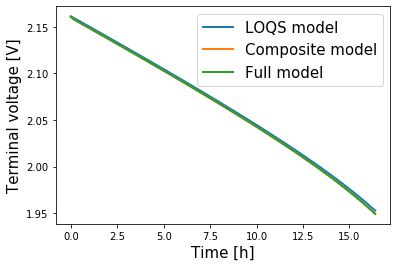

In [8]:
for model in models:
    t = solutions[model].t
    time = solutions[model]["Time [h]"](t)
    voltage = solutions[model]["Terminal voltage [V]"](t)
    plt.plot(time, voltage, lw=2, label=model.name)
plt.xlabel("Time [h]", fontsize=15)
plt.ylabel("Terminal voltage [V]", fontsize=15)
plt.legend(fontsize=15)
plt.show()

Alternatively, using `QuickPlot`, we can compare the values of some variables

In [9]:
solution_values = [solutions[model] for model in models]
quick_plot = pybamm.QuickPlot(solution_values)
import ipywidgets as widgets
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=16.38242960161448, step=0.05), Output()), _d…

If we update the current, setting it to be 20 A, we observe a greater discrepancy between the full model and the reduced-order models.

In [10]:
for model in models:
    solutions[model] = solver.solve(model, t_eval, inputs={"Current function [A]": 20})

# Plot
solution_values = [solutions[model] for model in models]
quick_plot = pybamm.QuickPlot(solution_values)
widgets.interact(quick_plot.plot, t=widgets.FloatSlider(min=0,max=quick_plot.max_t,step=0.05,value=0));

interactive(children=(FloatSlider(value=0.0, description='t', max=16.38242960161448, step=0.05), Output()), _d…